In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Find the date for last 12 months. 
# Calculate the date 1 year ago from today - Since all data is older than 1 year, changing the month count to 24 to bring in data
twentyfour_months = dt.date.today() - relativedelta(months=24)
print(f'Date for last 24 monhts: {twentyfour_months}')


Date for last 24 monhts: 2016-10-24


In [11]:
# Perform a query to retrieve the data and precipitation scores
measurement_list = session.query(Measurement).filter(Measurement.date >= twentyfour_months)
measurement_list_last_two_year = []

for m in measurement_list:
    measurement_list_last_two_year.append({'id': m.id, 'station': m.station, 'date': m.date, 'prcp': m.prcp, 'tobs': m.tobs})

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame.from_dict(measurement_list_last_two_year)

print('\n\nMeasurement dataframe full')      
display(measurement_df.head())
precipitation_df = measurement_df.set_index('date', drop = True, inplace = False)



Measurement dataframe full


,date,id,prcp,station,tobs
0,2016-10-24,2426,0.00,USC00519397,77.0
1,2016-10-25,2427,0.03,USC00519397,77.0
2,2016-10-26,2428,0.00,USC00519397,78.0
3,2016-10-27,2429,0.00,USC00519397,77.0
4,2016-10-28,2430,0.00,USC00519397,78.0


In [12]:
# Retreive Precipitation information only
precipitation_df = precipitation_df[['prcp']]
# Sort the dataframe by date
precipitation_df.sort_index(ascending=True, inplace=True)
precipitation_df.dropna(inplace = True)
print('\n\nMeasurement dataframe with only precipitation and date fields')
display(precipitation_df.head())




Measurement dataframe with only precipitation and date fields


,prcp
date,
2016-10-24,0.00
2016-10-24,0.08
2016-10-24,0.01
2016-10-24,0.00
2016-10-24,0.00


<IPython.core.display.Javascript object>


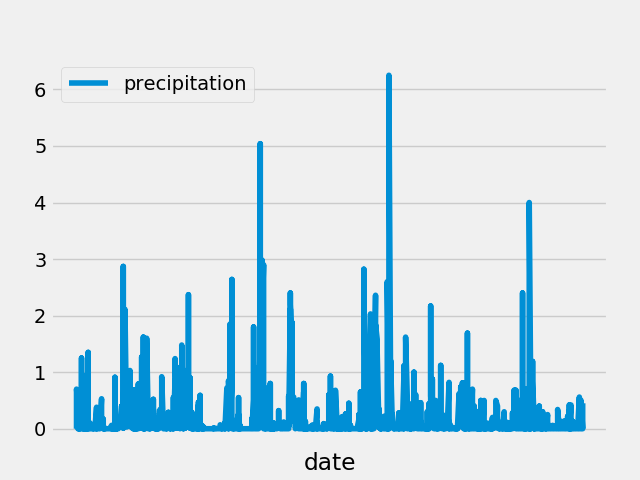

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(precipitation_df, label = 'precipitation')
plt.xlabel('date')
#plt.ylabel('precipitation')
plt.legend(['precipitation'],loc=2)
plt.grid(True,axis= 'both')
plt.xticks([])
#plt.xticks(rotation = 30)
plt.show()

# Rotate the xticks for the dates



In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,1665.000000
mean,0.165015
std,0.429135
min,0.000000
25%,0.000000
50%,0.010000
75%,0.120000
max,6.250000


In [15]:
# Read station table
station_list = session.query(Station).all()
station_list_all = []

for s in station_list:
    station_list_all.append({'id': s.id, 
                             'station': s.station, 
                             'name': s.name, 
                             'latitude': s.latitude, 
                             'longitude': s.longitude,
                             'elevation' : s.elevation})


# Save the query results as a Pandas DataFrame
station_df = pd.DataFrame.from_dict(station_list_all)
display(station_df)



,elevation,id,latitude,longitude,name,station
0,3.0,1,21.27160,-157.81680,"WAIKIKI 717.2, HI US",USC00519397
1,14.6,2,21.42340,-157.80150,"KANEOHE 838.1, HI US",USC00513117
2,7.0,3,21.52130,-157.83740,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830
3,11.9,4,21.39340,-157.97510,"PEARL CITY, HI US",USC00517948
4,306.6,5,21.49920,-158.01110,"UPPER WAHIAWA 874.3, HI US",USC00518838
5,19.5,6,21.33556,-157.71139,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523
6,32.9,7,21.45167,-157.84889,"WAIHEE 837.5, HI US",USC00519281
7,0.9,8,21.31520,-157.99920,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918
8,152.4,9,21.33310,-157.80250,"MANOA LYON ARBO 785.2, HI US",USC00516128


In [16]:
# How many stations are available in this dataset?
print(f'Total Number of Stations: {len(station_df)}')

Total Number of Stations: 9


In [17]:
# What are the most active stations?
# For this query, station df and precipitation df should be combined.
combined_df = pd.merge(measurement_df, station_df, how = 'inner',  on = 'station')
#print(combined_df.head())

# Do a groupby
active_station = combined_df.groupby(['station','name'])['prcp'].count().idxmax()
print(f'Most Active station: {active_station[1]}')
# List the stations and the counts in descending order.
combined_df.groupby(['station','name'])['prcp'].count().sort_values(ascending = False)


Most Active station: WAIKIKI 717.2, HI US


station      name                                  
USC00519397  WAIKIKI 717.2, HI US                      299
USC00519281  WAIHEE 837.5, HI US                       290
USC00513117  KANEOHE 838.1, HI US                      281
USC00516128  MANOA LYON ARBO 785.2, HI US              268
USC00519523  WAIMANALO EXPERIMENTAL FARM, HI US        256
USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US    221
USC00517948  PEARL CITY, HI US                          50
Name: prcp, dtype: int64

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperature_data_active_station = combined_df.loc[combined_df['station'] == 'USC00519397']['tobs']
temperature_data_active_station.describe()

count    299.000000
mean      74.481605
std        5.111065
min       60.000000
25%       71.000000
50%       76.000000
75%       78.500000
max       87.000000
Name: tobs, dtype: float64

<IPython.core.display.Javascript object>


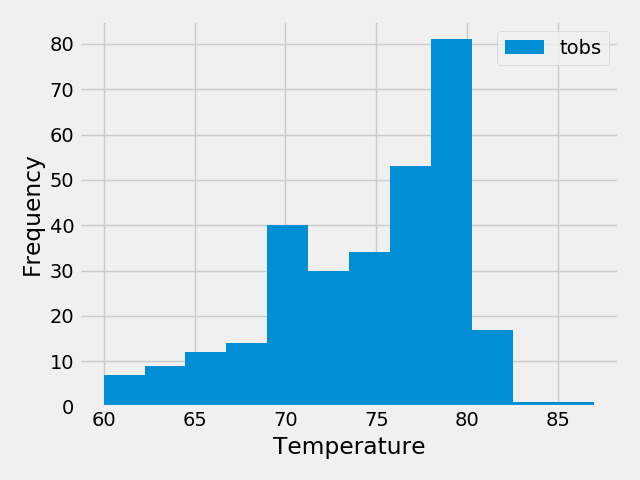

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 24 months of temperature observation data for this station and plot the results as a histogram
plt.figure()
hist = temperature_data_active_station.hist(bins=12)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.legend(['tobs'],loc=1)
plt.grid(True,axis= 'both')
#plt.xticks([])
#plt.xticks(rotation = 30)
plt.tight_layout()
plt.show()

plt.show()

In [20]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_avg_temp = calc_temps('2017-08-01', '2017-08-23')
trip_avg_temp


[(70.0, 78.82417582417582, 85.0)]

<IPython.core.display.Javascript object>


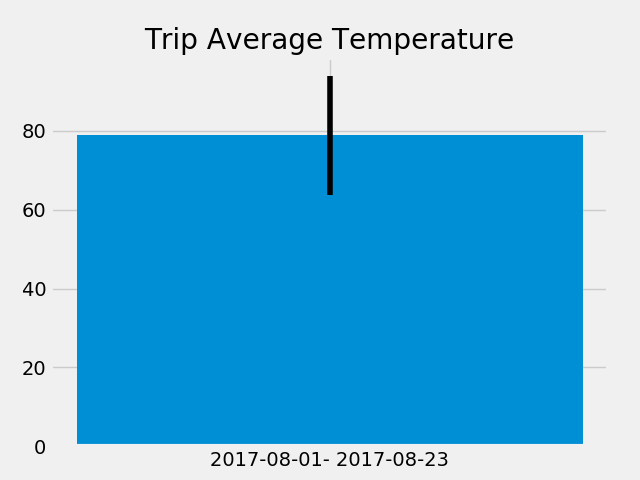

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure()

plt.bar(['2017-08-01- 2017-08-23'],trip_avg_temp[0][1], yerr = (trip_avg_temp[0][2] - trip_avg_temp[0][0]))
plt.title('Trip Average Temperature')
#plt.ylabel('precipitation')

#plt.xticks(rotation = 30)
plt.show()

# Rotate the xticks for the dates







In [23]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_rainfall(start_date, end_date):
    specific_date_df = combined_df.loc[(combined_df['date'] >= start_date) & (combined_df['date'] <= end_date) ]
    
    # Do a groupby
    # List the stations and the counts in descending order.
    return specific_date_df.groupby(['station','name', 'latitude', 'longitude'])['prcp'].sum().sort_values(ascending = False)

    
    
print(calc_rainfall('2017-08-01', '2017-08-23'))



station      name                                    latitude  longitude 
USC00516128  MANOA LYON ARBO 785.2, HI US            21.33310  -157.80250    3.85
USC00519281  WAIHEE 837.5, HI US                     21.45167  -157.84889    0.57
USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130  -157.83740    0.36
USC00519523  WAIMANALO EXPERIMENTAL FARM, HI US      21.33556  -157.71139    0.34
USC00519397  WAIKIKI 717.2, HI US                    21.27160  -157.81680    0.06
Name: prcp, dtype: float64


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
